**Preprocessing steps:**

Reformatting: Ensuring images have channels first (needed for deep learning models).

Rescaling: Adjusting pixel intensity values to a standard range.

Resizing: Standardizing all images to the same shape (128x128x64).

Cropping: Removing unnecessary empty space around the region of interest.

Reorienting: Aligning all images in the same standard medical orientation.

Creates Data Loaders: Packages the processed images into batches so they can be used for training/testing a deep learning model.


In [23]:
import os
from glob import glob

data_dir = "D:/monai/dataset/final"

train_images = sorted(glob(os.path.join(data_dir, "TrainVolumes", "*.nii.gz")))
train_labels = sorted(glob(os.path.join(data_dir, "TrainSegmentation", "*.nii.gz")))

test_images = sorted(glob(os.path.join(data_dir, "TestVolumes", "*.nii.gz")))
test_labels = sorted(glob(os.path.join(data_dir, "TestSegmentation", "*.nii.gz")))

print(f"Found {len(train_images)} train images and {len(train_labels)} train labels.")
print(f"Found {len(test_images)} test images and {len(test_labels)} test labels.")


Found 679 train images and 679 train labels.
Found 170 test images and 170 test labels.


In [21]:
import os
from glob import glob
#import shutil
#from tqdm import tqdm
#import dicom2nifti
#import numpy as np
#import nibabel as nib
from monai.transforms import (
    Compose,
    EnsureChannelFirstD,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,

)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism


def prepare(in_dir, pixdim=(1.5, 1.5, 1.0), a_min=-200, a_max=200, spatial_size=[128, 128, 64], cache=True):
    """
    This function is for preprocessing, it contains only the basic transforms, but you can add more operations that you
    find in the Monai documentation.
    https://monai.io/docs.html
    """

    set_determinism(seed=0)

    path_train_volumes = sorted(glob(os.path.join(in_dir, "TrainVolumes", "*.nii.gz")))
    path_train_segmentation = sorted(glob(os.path.join(in_dir, "TrainSegmentation", "*.nii.gz")))

    path_test_volumes = sorted(glob(os.path.join(in_dir, "TestVolumes", "*.nii.gz")))
    path_test_segmentation = sorted(glob(os.path.join(in_dir, "TestSegmentation", "*.nii.gz")))

    train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in
                   zip(path_train_volumes, path_train_segmentation)]
    test_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in
                  zip(path_test_volumes, path_test_segmentation)]

    train_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            EnsureChannelFirstD(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
            CropForegroundd(keys=["vol", "seg"], source_key="vol"),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),
            ToTensord(keys=["vol", "seg"]),

        ]
    )

    test_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            EnsureChannelFirstD(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
            CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),
            ToTensord(keys=["vol", "seg"]),

        ]
    )

    if cache:
        train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0)
        train_loader = DataLoader(train_ds, batch_size=1)

        test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0)
        test_loader = DataLoader(test_ds, batch_size=1)

        return train_loader, test_loader

    else:
        train_ds = Dataset(data=train_files, transform=train_transforms)
        train_loader = DataLoader(train_ds, batch_size=1)

        test_ds = Dataset(data=test_files, transform=test_transforms)
        test_loader = DataLoader(test_ds, batch_size=1)

        return train_loader, test_loader

In [25]:
train_loader, test_loader = prepare("D:/monai/dataset/final")

# Get first batch from training loader
train_batch = next(iter(train_loader))
print("Train batch keys:", train_batch.keys())  # Should print "vol" and "seg"
print("Train volume shape:", train_batch["vol"].shape)
print("Train segmentation shape:", train_batch["seg"].shape)


Loading dataset: 100%|██████████| 170/170 [03:10<00:00,  1.12s/it]

Train batch keys: dict_keys(['vol', 'seg', 'foreground_start_coord', 'foreground_end_coord'])
Train volume shape: torch.Size([1, 1, 128, 128, 64])
Train segmentation shape: torch.Size([1, 1, 128, 128, 64])


In [34]:
import matplotlib.pyplot as plt
import torch

def show_patient(data, SLICE_NUMBER=1, train=True, test=False):
    """
    Displays a specific slice of a patient's medical scan from training or testing datasets.

    Parameters:
    - data: A tuple containing (training_data, testing_data) - DataLoaders.
    - SLICE_NUMBER: The slice number to be displayed.
    - train: Boolean, if True, displays a patient from the training set.
    - test: Boolean, if True, displays a patient from the testing set.
    """
    
    train_loader, test_loader = data

    # Fetch first batch
    train_batch = next(iter(train_loader)) if train else None
    test_batch = next(iter(test_loader)) if test else None

    # Check if valid data is available
    if train and train_batch:
        vol = train_batch["vol"][0, 0].detach().cpu().numpy()  # Extract first sample, first channel
        seg = train_batch["seg"][0, 0].detach().cpu().numpy()  # Extract segmentation
        
        # Ensure SLICE_NUMBER is within valid range
        if SLICE_NUMBER < 0 or SLICE_NUMBER >= vol.shape[2]:
            print(f"Error: SLICE_NUMBER {SLICE_NUMBER} out of range! Max slice index is {vol.shape[2] - 1}.")
            return

        plt.figure(figsize=(12, 6))

        # Display the volume slice
        plt.subplot(1, 2, 1)
        plt.title(f"Train Volume Slice {SLICE_NUMBER}")
        plt.imshow(vol[:, :, SLICE_NUMBER], cmap="gray")

        # Display the segmentation mask
        plt.subplot(1, 2, 2)
        plt.title(f"Train Segmentation Slice {SLICE_NUMBER}")
        plt.imshow(seg[:, :, SLICE_NUMBER], cmap="gray")

        plt.show()

    if test and test_batch:
        vol = test_batch["vol"][0, 0].detach().cpu().numpy()
        seg = test_batch["seg"][0, 0].detach().cpu().numpy()
        
        if SLICE_NUMBER < 0 or SLICE_NUMBER >= vol.shape[2]:
            print(f"Error: SLICE_NUMBER {SLICE_NUMBER} out of range! Max slice index is {vol.shape[2] - 1}.")
            return
        
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.title(f"Test Volume Slice {SLICE_NUMBER}")
        plt.imshow(vol[:, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"Test Segmentation Slice {SLICE_NUMBER}")
        plt.imshow(seg[:, :, SLICE_NUMBER], cmap="gray")

        plt.show()


Loading dataset: 100%|██████████| 170/170 [03:05<00:00,  1.09s/it]


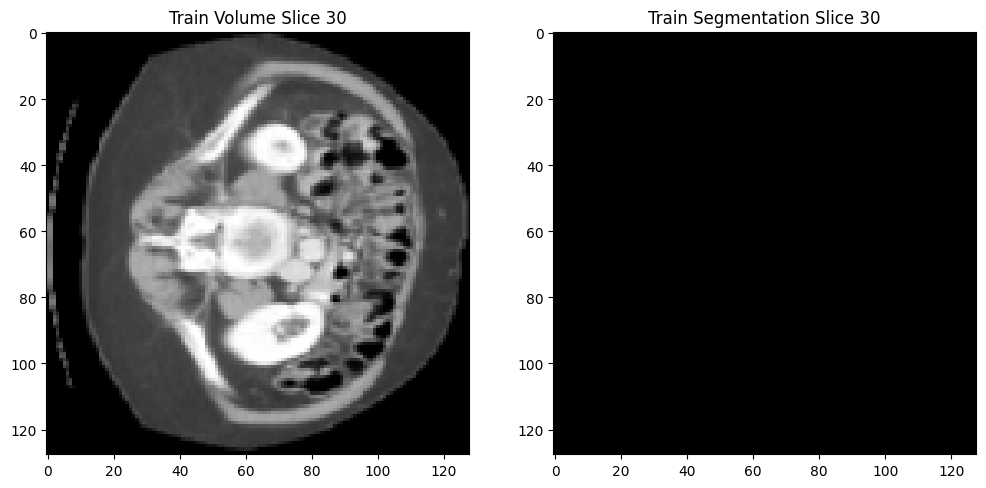

In [38]:
train_loader, test_loader = prepare("D:/monai/dataset/final")
show_patient((train_loader, test_loader), SLICE_NUMBER=30, train=True)
